## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333) 
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

## 1. 請改變 reduce_lr的patience和factor並比較

In [8]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

In [11]:
results = {}
for factor in [0.3, 0.5]:
    for patience in [5, 25]:
        reduce_lr = ReduceLROnPlateau(factor=factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=patience, 
                              verbose=1)
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True,
                  callbacks=[reduce_lr]
                 )

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
        
        exp_name_tag = "exp-fac:%f-pat:%d" % (factor,patience)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_15 (Batc (None, 128)               512       
__________

50000/50000 [==============================] - 3s 63us/step - loss: 0.8444 - acc: 0.7277 - val_loss: 1.4712 - val_acc: 0.5028
Epoch 48/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.8449 - acc: 0.7288 - val_loss: 1.4712 - val_acc: 0.5027
Epoch 49/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.8443 - acc: 0.7277 - val_loss: 1.4712 - val_acc: 0.5028
Epoch 50/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.8446 - acc: 0.7276 - val_loss: 1.4713 - val_acc: 0.5029
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048     

50000/50000 [==============================] - 3s 63us/step - loss: 0.5855 - acc: 0.8269 - val_loss: 1.5832 - val_acc: 0.4992
Epoch 46/50
50000/50000 [==============================] - 3s 64us/step - loss: 0.5629 - acc: 0.8376 - val_loss: 1.5873 - val_acc: 0.4981
Epoch 47/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.5541 - acc: 0.8414 - val_loss: 1.5994 - val_acc: 0.4931
Epoch 48/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.5485 - acc: 0.8443 - val_loss: 1.5947 - val_acc: 0.4961
Epoch 49/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.5422 - acc: 0.8460 - val_loss: 1.6083 - val_acc: 0.4956
Epoch 50/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.5371 - acc: 0.8489 - val_loss: 1.6000 - val_acc: 0.4982
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)           

50000/50000 [==============================] - 3s 62us/step - loss: 0.7681 - acc: 0.7588 - val_loss: 1.4835 - val_acc: 0.5035
Epoch 43/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.7652 - acc: 0.7600 - val_loss: 1.4842 - val_acc: 0.5030
Epoch 44/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.7645 - acc: 0.7589 - val_loss: 1.4840 - val_acc: 0.5041
Epoch 45/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.7623 - acc: 0.7599 - val_loss: 1.4858 - val_acc: 0.5019
Epoch 46/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.7612 - acc: 0.7609 - val_loss: 1.4868 - val_acc: 0.5006

Epoch 00046: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 47/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.7591 - acc: 0.7613 - val_loss: 1.4853 - val_acc: 0.5060
Epoch 48/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.7576 - acc: 0.7637 - 

50000/50000 [==============================] - 3s 62us/step - loss: 0.6757 - acc: 0.7881 - val_loss: 1.5462 - val_acc: 0.5016
Epoch 41/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.6585 - acc: 0.7956 - val_loss: 1.5396 - val_acc: 0.5006
Epoch 42/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.6397 - acc: 0.8026 - val_loss: 1.5647 - val_acc: 0.4944
Epoch 43/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.6221 - acc: 0.8098 - val_loss: 1.5708 - val_acc: 0.4963
Epoch 44/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.6036 - acc: 0.8181 - val_loss: 1.5941 - val_acc: 0.4878
Epoch 45/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.5868 - acc: 0.8236 - val_loss: 1.5857 - val_acc: 0.5010
Epoch 46/50
50000/50000 [==============================] - 3s 62us/step - loss: 0.5704 - acc: 0.8300 - val_loss: 1.6039 - val_acc: 0.4941

Epoch 00046: ReduceLROnPlateau reducing learn

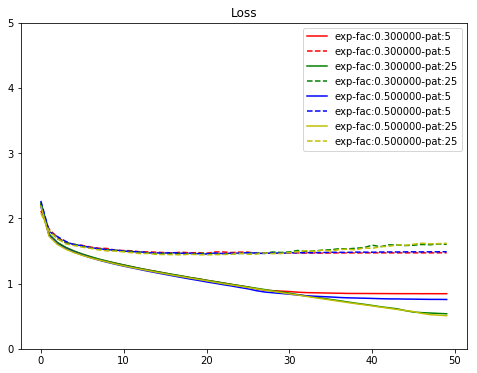

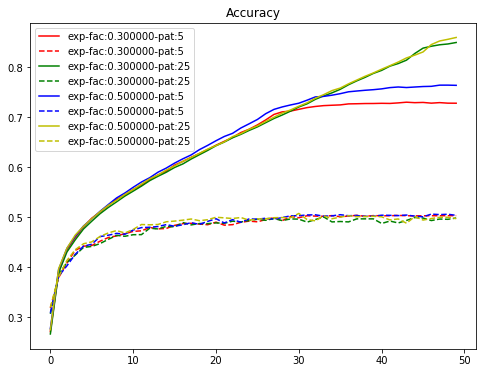

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## 2. 請將optimizer換成Adam、RMSprop搭配reduce_lr

In [13]:
results = {}
for opt in ['adam', 'rmsprop']:
    reduce_lr = ReduceLROnPlateau(factor=0.5, 
                          min_lr=1e-12, 
                          monitor='val_loss', 
                          patience=5, 
                          verbose=1)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=opt)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "exp-opt:%s" % (opt)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_27 (Batc (None, 128)               512       
__________

Epoch 46/50
50000/50000 [==============================] - 3s 69us/step - loss: 0.2660 - acc: 0.9453 - val_loss: 1.6794 - val_acc: 0.5241
Epoch 47/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.2651 - acc: 0.9452 - val_loss: 1.6815 - val_acc: 0.5258
Epoch 48/50
50000/50000 [==============================] - 4s 71us/step - loss: 0.2646 - acc: 0.9460 - val_loss: 1.6851 - val_acc: 0.5261

Epoch 00048: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 49/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.2623 - acc: 0.9464 - val_loss: 1.6823 - val_acc: 0.5251
Epoch 50/50
50000/50000 [==============================] - 3s 68us/step - loss: 0.2615 - acc: 0.9470 - val_loss: 1.6839 - val_acc: 0.5250
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_______________________________

50000/50000 [==============================] - 3s 65us/step - loss: 0.2867 - acc: 0.9303 - val_loss: 1.6950 - val_acc: 0.5328
Epoch 42/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.2843 - acc: 0.9328 - val_loss: 1.6994 - val_acc: 0.5360
Epoch 43/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.2826 - acc: 0.9326 - val_loss: 1.7041 - val_acc: 0.5349
Epoch 44/50
50000/50000 [==============================] - 3s 64us/step - loss: 0.2805 - acc: 0.9334 - val_loss: 1.7092 - val_acc: 0.5309
Epoch 45/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.2776 - acc: 0.9339 - val_loss: 1.7112 - val_acc: 0.5319

Epoch 00045: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 46/50
50000/50000 [==============================] - 3s 65us/step - loss: 0.2742 - acc: 0.9355 - val_loss: 1.7157 - val_acc: 0.5344
Epoch 47/50
50000/50000 [==============================] - 3s 63us/step - loss: 0.2729 - acc: 0.9366 -

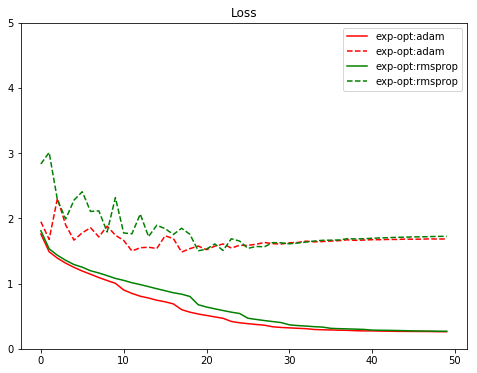

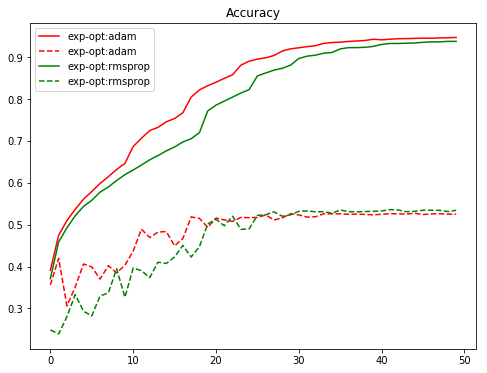

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()